In [1]:

# Import libraries

import simpy
import random
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set Simulation Global Variables
PASSENGER_INTERVAL = 5
NUM_FLOORS = 10
NUM_ELEVATORS = 4
MAX_CAPACITY = 6    # per elevator capacity
MINUTES_IN_DAY = 24 * 60 # Total simulation time in minutes
SIM_TIME = MINUTES_IN_DAY # Total simulation time in minutes
CHECK_INTERVAL = 1
# event log is used to keep a chronological record of every time a passenger is generated for an elevator 
event_log = []

"""DON'T DO LOW_WAIT_TIME IT'S BUGGED AND IT FILLS UP"""
STRATEGY = 'low_ride_time'
    # low_ride_time, low_wait_time, sweep
    

In [2]:
def get_arrival_rate(current_time_minutes, floor):
    """
    returns the arrival rate  based on time of day and floor.
    
    arrival patterns:
    Morning (7:30-8:30 AM): High ground floor arrivals 
    Lunch (12:00-1:00 PM): High arrivals from all floors 
    Evening (5:00-6:00 PM): High arrivals from upper floors (people leaving work)
    Night/Off-peak: Low arrivals from all floors 
    """
    
    # convert time to minutes 
    time_of_day = current_time_minutes % 1440
    
    # hard coded arrival rates 
    high_rate = 0.5      # Peak traffic
    medium_rate = 0.2    # Moderate traffic  
    low_rate = 0.05      # Off-peak traffic
    
    # time periods
    morning_start, morning_end = 450, 510      # 7:30-8:30 AM
    lunch_start, lunch_end = 720, 780          # 12:00-1:00 PM  
    evening_start, evening_end = 1020, 1080   # 5:00-6:00 PM
    
    # determine time period and apply floor-specific rates by checking to see which band the current time falls into
    if morning_start <= time_of_day <= morning_end:
        
        if floor == 0:  
            return high_rate
        else:
            return low_rate
            
    elif lunch_start <= time_of_day <= lunch_end:
        
        if floor == 0:  
            return low_rate  
        else:
            return high_rate  
            
    elif evening_start <= time_of_day <= evening_end:
        
        if floor == 0:  
            return low_rate
        else:
            return high_rate
            
    else:  
        return medium_rate
    

In [3]:
def get_time_period(current_time_minutes):
    
    time_of_day = current_time_minutes % 1440
    
    if 450 <= time_of_day <= 510:
        return "morning"
    elif 720 <= time_of_day <= 780:
        return "lunch"
    elif 1020 <= time_of_day <= 1080:
        return "evening"
    else:
        return "off_peak"

In [4]:
def generate_destination(pickup_floor, time_period, num_floors):
    """
    generate destinations based on pickup floor and time of day
    """

    if time_period == "morning" and pickup_floor == 0:
        # Morning arrivals at ground floor typically go up
        return random.randint(1, num_floors - 1)
    
    elif time_period in ["lunch", "evening"] and pickup_floor > 0:

        # Lunch/evening departures from upper floors typically go to ground
        if random.random() < 0.8:  # 80% chance to go to ground floor
            return 0
        
        else:
            # 20% chance to go to another floor
            destination = random.randint(0, num_floors - 1)
            while destination == pickup_floor:
                destination = random.randint(0, num_floors - 1)
            return destination
    else:
        # Random destination for other cases
        destination = random.randint(0, num_floors - 1)
        while destination == pickup_floor:
            destination = random.randint(0, num_floors - 1)
        return destination


In [5]:
class Passenger:
    def __init__(self, pid, pickup, destination, start_time):
        self.id = pid
        self.pickup = pickup
        self.destination = destination
        self.start_time = start_time  # Track when passenger enters system
    
    def __repr__(self, color = '\033[97m'):         # changes representation of passenger to be easier to read
        return f"{color}P{self.id}({self.pickup} --> {self.destination})"

In [6]:
class Dispatcher:
    def __init__(self, elevators):
        self.elevators = elevators


    # weight elevator assignment based on distance and number of pickup_requests
    def assign_passenger(self, passenger):
        def elevator_score(e):
            distance = abs(e.floor - passenger.pickup)
            load = len(e.onboard) + sum(len(v) for v in e.pickup_requests.values())
            return distance + 2*load
        best_elevator = min(self.elevators, key = elevator_score)
        

        best_elevator.request_pickup(passenger)

In [7]:

def passenger_generator(env, dispatcher, num_floors=NUM_FLOORS, check_interval=CHECK_INTERVAL):
    """
    Generate passengers using Bernoulli trials.
    
    How it works:
    1. Every 'check_interval' minutes, check each floor
    2. For each floor, get the arrival rate (passengers/minute)
    3. Convert rate to probability: P(arrival) = rate × interval
    4. Use random() < probability to decide if passenger arrives
    5. If yes, create passenger with realistic destination
    """
    pid = 1
    
    while True:
        current_time_str = time_to_string(env.now)
        time_period = get_time_period(env.now)
        
        # Print current rates
        if env.now % 60 == 0:  # Print every hour
            print(f"[{current_time_str}] Time period: {time_period}")
            for floor in range(num_floors):
                rate = get_arrival_rate(env.now, floor)
                prob = rate * check_interval
                print(f"  Floor {floor}: rate={rate:.3f}/min, prob={prob:.3f}")
        
        # Check each floor for potential passenger arrivals
        for floor in range(num_floors):
            arrival_rate = get_arrival_rate(env.now, floor)
            
            # Convert rate to probability for this time interval
            # For small intervals: P(arrival in interval) ≈ rate × interval
            arrival_probability = arrival_rate * check_interval
            
            # Bernoulli trial: does a passenger arrive?
            if random.random() < arrival_probability:
                
                # Generate realistic destination
                destination = generate_destination(floor, time_period, num_floors)
                
                # Create passenger
                start_time = env.now
                passenger = Passenger(pid, floor, destination, start_time)
                
                # Assign to dispatcher
                dispatcher.assign_passenger(passenger)
                
                # Log passenger creation
                print(f"[{current_time_str}] Passenger {pid} appears at floor {floor}, wants to go to {destination} (Period: {time_period})")
                
                event_log.append({'timestamp': env.now, 'floor_number': floor})
                
                pid += 1
        
        # Wait for next check
        yield env.timeout(check_interval)


In [8]:
def time_to_string(minutes):
    """Convert minutes from midnight to HH:MM format"""
    hours = int(minutes // 60) % 24
    mins = int(minutes % 60)
    return f"{hours:02d}:{mins:02d}"

In [9]:
class Elevator:
    def __init__(self, env, num_floors, max_capacity, strategy, eid=0):
        self.env = env
        self.id = eid
        self.floor = 0          # Start at ground floor (0)
        self.direction = 'up'   # up or down
        self.num_floors = num_floors # total
        self.max_capacity = max_capacity
        self.pickup_requests = {floor: [] for floor in range(num_floors)}
        self.onboard = []
        self.strategy = strategy
        self.stats = {
            'total_passengers': 0,
            'total_wait_time': 0,
            'total_travel_time': 0
        }

    def log(self, message):
        current_time = time_to_string(self.env.now)
        print(f"    [{current_time}] Elevator {self.id} at floor: {self.floor} | {message}")

    def request_pickup(self, passenger):
        self.pickup_requests[passenger.pickup].append(passenger)
        self.log(f"Passenger {passenger.id} requests a pickup at floor {passenger.pickup}")

    # longest waiting passenger
    def find_longest_waiting_request(self):
        longest_wait_time = -1
        target_floor = None
        for floor, passengers in self.pickup_requests.items():
            if not passengers:
                continue
            for p in passengers:
                wait_time = self.env.now - p.start_time
                if wait_time > longest_wait_time:
                    longest_wait_time = wait_time
                    target_floor = floor
        return target_floor

    # off-load, on-board, logic, 
    def run_elevator(self):
        while True:
            # 1) Off-load passengers at current floor
            offboarding = [p for p in self.onboard if p.destination == self.floor]
            for p in offboarding:
                self.onboard.remove(p)
                travel_time = self.env.now - p.start_time
                self.stats['total_travel_time'] += travel_time
                self.stats['total_passengers'] += 1
                self.log(f"Dropped off {p} (travel time: {travel_time:.1f} min)")

            # 2) On-board passengers at current floor
            boarding = self.pickup_requests[self.floor]
            remaining = []
            for p in boarding:
                if len(self.onboard) < self.max_capacity:
                    self.onboard.append(p)
                    wait_time = self.env.now - p.start_time
                    self.stats['total_wait_time'] += wait_time
                    self.log(f"Picked up {p} (wait time: {wait_time:.1f} min)")
                else:
                    remaining.append(p)
                    self.log(f"Elevator full, {p} must wait")
            
            self.pickup_requests[self.floor] = remaining

            if not any(self.pickup_requests.values()) and not self.onboard:
                #self.log("idle")
                yield self.env.timeout(1)
                continue
            

            # 3) Logic
            # 
            # 3a) Move Logic if logic = 'low_ride_time'
            """ If Passengers: Drop off first passenger 
                Else: Go to Requests
                Else: Go to floor 0                         """
            if self.strategy == "low_ride_time":
                if self.onboard:
                    dests = [q.destination for q in self.onboard]
                    target = dests[0]
                    self.log(f"Moving {self.direction} toward floor {target}")
                    if target > self.floor:
                        self.direction = 'up'
                        self.floor +=1
                    elif target < self.floor:
                        self.direction = 'down'
                        self.floor -=1
                    
                else:
                    target = self.find_longest_waiting_request()
                    self.log(f"Moving {self.direction} toward floor {target}")
                    if target > self.floor:
                        self.direction = 'up'
                        self.floor +=1
                    elif target < self.floor:
                        self.direction = 'down'
                        self.floor -=1

            #3b)    Low_wait_time
            if self.strategy == "low_wait_time":
                if self.pickup_requests:
                    target = self.find_longest_waiting_request()
                    if target is not None:
                        self.log(f"Moving {self.direction} toward floor {target}")
                        if target > self.floor:
                            self.direction = 'up'
                            self.floor +=1
                        elif target < self.floor:
                            self.direction = 'down'
                            self.floor -=1
                else: 
                    dests = [q.destination for q in self.onboard]
                    target = dests[0]
                    self.log(f"Moving {self.direction} toward floor {target}")
                    if target > self.floor:
                        self.direction = 'up'
                        self.floor +=1
                    elif target < self.floor:
                        self.direction = 'down'
                        self.floor -=1


            #3c) if logic = "sweep"
                
                

# 4) Wait for travel time (e.g. 1 time-unit per floor)
            yield self.env.timeout(.5)

In [10]:
            # # 3) Move logic based on strategy
            # if self.strategy == "longest_wait":
            #     target_floor = self.find_longest_waiting_request()
    
            #     if target_floor is not None and target_floor != self.floor:
            #         if target_floor > self.floor:
            #             self.direction = 'up'
            #             self.floor += 1
            #         elif target_floor < self.floor:
            #             self.direction = 'down'
            #             self.floor -= 1
            #             self.log(f"Moving {self.direction} toward floor {target_floor}")
            #     else:
            #     # No passengers waiting → continue in current direction
            #         self.log("No pickups pending, continuing current direction")
            #         if self.direction == 'up':
            #             if self.floor < self.num_floors - 1:
            #                 self.floor += 1
            #             else:
            #                 self.direction = 'down'
            #                 self.floor -= 1
            #         else:
            #             if self.floor > 0:
            #                 self.floor -= 1
            #             else:
            #                 self.direction = 'up'
            #                 self.floor += 1
            # else:
            # # Default nearest (up/down sweep)
            #     if self.direction == 'up':
            #         if self.floor < self.num_floors - 1:
            #             self.floor += 1
            #         else:
            #             self.direction = 'down'
            #             self.floor -= 1
            #     else:
            #         if self.floor > 0:
            #             self.floor -= 1
            #         else:
            #             self.direction = 'up'
            #             self.floor += 1
            # self.log(f"Moving {self.direction} to floor {self.floor}")

In [11]:
class Elevator_Controller:
    def __init__(self, env, NUM_ELEVATORS, NUM_FLOORS):
        self.env = env
        self.elevators = [Elevator(env, NUM_FLOORS, max_capacity=MAX_CAPACITY, strategy = STRATEGY,eid=i) for i in range(NUM_ELEVATORS)]
        self.dispatcher = Dispatcher(self.elevators)

    def start(self):
        for elevator in self.elevators:
            self.env.process(elevator.run_elevator())

In [12]:
def print_simulation_stats(controller):
    """Print simulation statistics"""
    total_passengers = 0
    total_wait_time = 0.0
    total_travel_time = 0.0
    total_remaining = 0
    print("\n" + "="*50)
    print("SIMULATION STATISTICS")
    print("="*50)
    for i, elevator in enumerate(controller.elevators):
        passengers = elevator.stats['total_passengers']
        wait = elevator.stats['total_wait_time']
        travel = elevator.stats['total_travel_time']
        total_passengers += passengers
        total_wait_time += wait
        total_travel_time += travel

        remaining_onboard = len(elevator.onboard)
        remaining_pickups = sum(len(v) for v in elevator.pickup_requests.values())
        total_remaining += (remaining_onboard + remaining_pickups)

        print(f"Elevator {i+1}:")
        print(f"Passengers Served: {passengers}")
        print(f"Average wait time: {wait / passengers:.1f}")
        print(f"Average total time: {travel / passengers:.1f}")
        print("-"*50)
    print(f"Total passengers served: {total_passengers}")
    print(f"Passengers still in system: {total_remaining}")

    
    # if elevator.stats['total_passengers'] > 0:
    #     avg_wait_time = elevator.stats['total_wait_time'] / elevator.stats['total_passengers']
    #     avg_travel_time = elevator.stats['total_travel_time'] / elevator.stats['total_passengers']
    #     print(f"Average wait time: {avg_wait_time:.1f} minutes")
    #     print(f"Average travel time: {avg_travel_time:.1f} minutes")
    # print(f"Simulation duration: {SIM_TIME} minutes ({SIM_TIME/60:.1f} hours)")
    # print(f"total passengers {[elevator.stats['total_passengers']]}")
    # print("="*50)
    # print(sum(ele.stats['total_passengers'] for ele in controller.elevators))

In [13]:
# Run the simulation
if __name__ == "__main__":
    random.seed(23)
    env = simpy.Environment()
    elevator = Elevator(env, num_floors=NUM_FLOORS, max_capacity=MAX_CAPACITY, strategy="longest_wait")  # or "nearest"
    controller = Elevator_Controller(env, NUM_ELEVATORS, NUM_FLOORS)
    controller.start()
    env.process(passenger_generator(env, controller.dispatcher))
    
    # Start both processes
    # env.process(passenger_generator(env, elevator))
    # env.process(elevator.run_elevator())
    
    print(f"Starting 24-hour elevator simulation...")
    print(f"Simulation will run for {SIM_TIME} minutes ({SIM_TIME/60:.1f} hours)")
    print("-" * 50)
    
    env.run(until=SIM_TIME)
    
    print_simulation_stats(controller) 

Starting 24-hour elevator simulation...
Simulation will run for 1440 minutes (24.0 hours)
--------------------------------------------------
[00:00] Time period: off_peak
  Floor 0: rate=0.200/min, prob=0.200
  Floor 1: rate=0.200/min, prob=0.200
  Floor 2: rate=0.200/min, prob=0.200
  Floor 3: rate=0.200/min, prob=0.200
  Floor 4: rate=0.200/min, prob=0.200
  Floor 5: rate=0.200/min, prob=0.200
  Floor 6: rate=0.200/min, prob=0.200
  Floor 7: rate=0.200/min, prob=0.200
  Floor 8: rate=0.200/min, prob=0.200
  Floor 9: rate=0.200/min, prob=0.200
    [00:00] Elevator 0 at floor: 0 | Passenger 1 requests a pickup at floor 3
[00:00] Passenger 1 appears at floor 3, wants to go to 9 (Period: off_peak)
    [00:00] Elevator 1 at floor: 0 | Passenger 2 requests a pickup at floor 9
[00:00] Passenger 2 appears at floor 9, wants to go to 7 (Period: off_peak)
    [00:01] Elevator 0 at floor: 0 | Moving up toward floor 3
    [00:01] Elevator 1 at floor: 0 | Moving up toward floor 9
    [00:01] Eleva

Arrival counts by elevator and hour:
 hour          0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
floor_number                                          ...                       
0             11  12  17  14  10  10  11  24  23   9  ...   5  14   9   2   9   
1             11   6   7   9  16   9  14  12   8   8  ...  12  14  12  33  15   
2             10  11  12  10  13  17   9   5   7  12  ...  15  15  14  25   8   
3             13  13  12  13  13   9  15   6   7  13  ...  13  18  14  37   7   
4             13  13  19  18  15  13  18   7   6  19  ...  15  13  12  30  17   
5              8   8  19  10  14  11  13  12   4  14  ...   7  12  14  32  16   
6             18  13  14  14   7  12  14   7  11   9  ...  15  13  11  28  14   
7             14  13  10   8  18   6   9   9   6  14  ...  18  18  10  30  18   
8             16  12  12   9  12  16  10  11   9  14  ...  15  16  10  27  14   
9             15  15  13  11  11  11  15   9   8  13  ...  11   7  13  

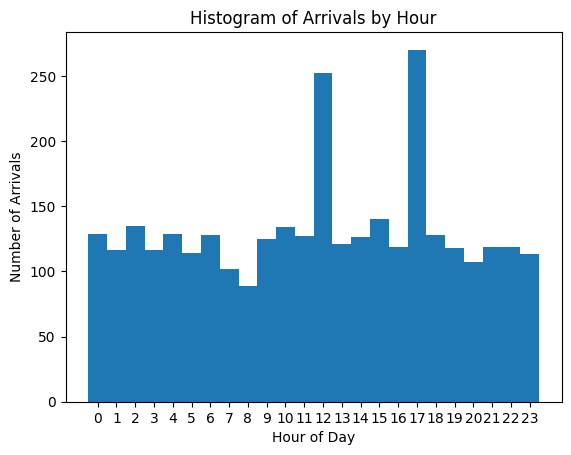

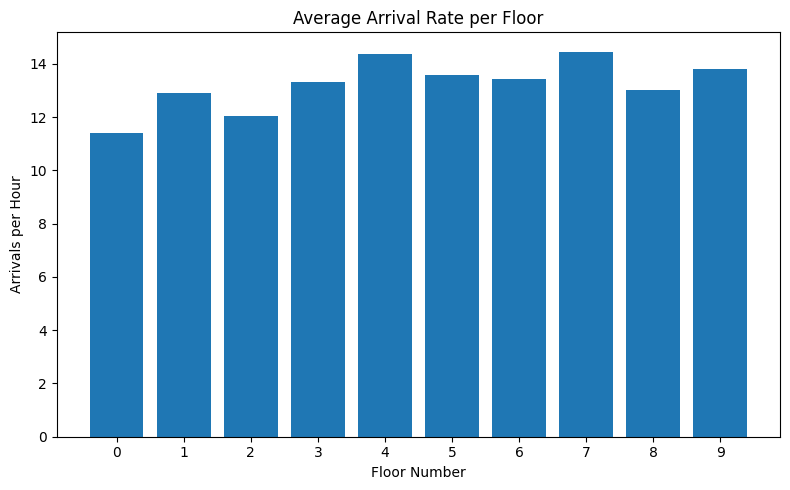

In [14]:
events = pd.DataFrame(event_log)
events['hour'] = (events['timestamp'] // 60).astype(int) % 24

arrival_counts = events.groupby(['floor_number','hour']).size().unstack(fill_value=0)
total_arrivals = events['floor_number'].value_counts().sort_index()
sim_hours = SIM_TIME / 60.0
arrival_rate_per_hour = total_arrivals / sim_hours
print("Arrival counts by elevator and hour:\n", arrival_counts)

rate_table = arrival_rate_per_hour.rename('arrivals_per_hour') \
                                 .to_frame() \
                                 .reset_index() \
                                 .rename(columns={'index':'floor_number'})
print(rate_table)

# plot histogram of arrivals by hour
plt.figure()
plt.hist(events['hour'], bins=range(25), align='left')
plt.xticks(range(24))
plt.xlabel('Hour of Day')
plt.ylabel('Number of Arrivals')
plt.title('Histogram of Arrivals by Hour')
plt.show()

# plot arrivals per hour by floor over whole simulation
plt.figure(figsize=(8, 5))
plt.bar(rate_table['floor_number'].astype(str), rate_table['arrivals_per_hour'])
plt.xlabel('Floor Number')
plt.ylabel('Arrivals per Hour')
plt.title('Average Arrival Rate per Floor')
plt.tight_layout()
plt.show()



ride - avg time total 7.9
        total served 3166
        in system 10
